# ➡️ **LAB02:** Optimization algorithms

In this exercise, you're going to implement different optimization algorithms in Pytorch from scratch. Optimization algorithms are at the core of deep learning, as they power the training of models by minimizing loss functions and finding the best parameters.

In this session, you’ll:
- **Understand** the mathematical foundations of 5 commonly used optimization algorithms.
- **Implement** the optimization algorithms into Pytorch.
- **Compare** the accuracies of the 5 optimization algorithms. 

By the end of this session, you will not only understand *how* these algorithms work but also gain a deeper appreciation of their *pros* and *cons* when training neural networks. Let’s get started!

### Import libraries
Let's start with importing the necessary software libraries.

In [1]:
import platform
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils.lab02 import *

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## check whether we are working on MAC or else (Windows, Linux)
if platform.system() == "Darwin":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seed for reproducibility
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda


### MNIST dataset loaders
Download or load the MNIST dataset, and make a dataloader for Pytorch

The MNIST dataset consists of 70,000 grayscale images of handwritten digits (0-9), each 28×28 pixels. It is split into 60,000 training images and 10,000 test images. Its creation played a crucial role in advancing convolutional neural networks (CNNs), as Yann LeCun's work on MNIST helped establish CNNs as a powerful tool for image recognition.

<img src="https://camo.githubusercontent.com/3f774dcd5fee6c64e7ddef90158db6d68ac72405ad5a8a705c09ebdcf4f99192/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067">

In [2]:
batch_size = 100
n_iters = 3000

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Instantiate the neural network, loss function, and accuracies

In [3]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

criterion = nn.CrossEntropyLoss()
accuracies = {}

### Steps:
1. The code for the first optimizer, **Stochastic Gradient Descent (SGD)**, has been prepared. Read the text, inspect the code and run it.

2. For the remaining optimization algorithms read the text, interpret the equations and implement the algorithm from scratch using the **SGD** code as example:
    1. **SGD with Momentum**

    2. **Adagrad**

    3. **RMSProp**
    
    4. **Adam**
    
3. Evaluate the performance of the 5 optimization algorithms.  

### **Optimizer 1:** Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm: we take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta \mathcal{L}(\theta_t)$, multiplied by the learning rate, $\eta$. 

The learning rate is an important hyperparameter that controls the magnitude of the parameter update. If our learning rate is too small then our parameter updates will also be too small for us to train our model in a reasonable amount of time. Conversely, if our learning rate is too large then the size of the parameter updates will be so large that learning will become unstable! If you ever get a `NaN` value for your loss, one of the first things to try would be lowering the learning rate.

The SGD algorithm is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta \mathcal{L}(\theta_t)$$

In this notebook we'll use the term SGD, but we're formally implementing the **mini-batch gradient descent**. The general rule of thumb is that nowadays when someone mentions stochastic gradient descent then they mean mini-batch gradient descent. 

In PyTorch, the optimizer is called **SGD** even though it can do any of the gradient descent variants. In the code below the PyTorch methods with a trailing underscore, e.g., `.add_`, means the operation is in-place which overwrites the input tensor without keeping its previous values, thus saving memory. 

In [4]:
class SGD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)
        
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update)

### Train the neural network with the SGD optimizer

In [5]:
model = FeedforwardNeuralNetModel(input_dim=28*28, hidden_dim=100, output_dim=10)
optimizer = SGD(model.parameters(), lr=1e-2)
accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
accuracies["SGD"] = accuracy

Iteration: 500. Loss: 1.1475591659545898. Accuracy: 80.58999633789062
Iteration: 1000. Loss: 0.6737625002861023. Accuracy: 86.76000213623047
Iteration: 1500. Loss: 0.5912519693374634. Accuracy: 88.66000366210938
Iteration: 2000. Loss: 0.45264750719070435. Accuracy: 89.38999938964844
Iteration: 2500. Loss: 0.49295079708099365. Accuracy: 89.97000122070312
Iteration: 3000. Loss: 0.4112313985824585. Accuracy: 90.44999694824219


### **Optimizer 2:** SGD with Momentum

One way to think of SGD is a ball rolling down a hill, where areas of high gradient are steep parts of the hill and areas of low gradient are very flat areas. Sometimes the global minima, the point with the lowest loss, is in the middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small update steps which makes learning slow. 

We'd want to add something to our optimizer that made it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas. 

That's exact what SGD with momentum does! Our parameter update is now calculated using a velocity, $v$, which depends on previous velocity multiplied by the momentum $\beta$. Commonly used momentum values are usually around 0.9ish. Here were are implementing the version where the gradient contribution is scaled relative to the momentum factor (omitting the learning rate inside the velocity term):

\begin{align*}
    v_{t} &= \beta \cdot v_{t-1} + (1-\beta) \cdot \nabla_\theta \mathcal{L}(\theta_{t})\\
    \theta_{t+1} &= \theta_{t} - \eta \cdot v_{t}\\
\end{align*}

<br>

**Tips:** 
- `self.param_momentum` is a dictionary that keeps track of the "momentum" (the moving average of gradients) for each parameter.

- Each time `update_param` is called, the momentum should be updated with the current gradient `p.grad`, and it should overwrite the `self.param_momentum[p]`: it is the running average of gradients, therefore `=` suffices in the code below.

- The momentum term ($v_{t}$) helps the optimizer "remember" past gradients, leading to smoother updates and potentially faster convergence.

<br>

**To Do: implement SGD with momentum in the code below**

In [6]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # dictionary to store the model parameters as key "p"
        
    def update_param(self, p):
        self.param_momentum[p] = self.beta * self.param_momentum[p] + (1 - self.beta) * p.grad
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

### Train the neural network with SGD with Momentum optimizer

In [7]:
model = FeedforwardNeuralNetModel(input_dim=28*28, hidden_dim=100, output_dim=10)
optimizer = SGDMomentum(model.parameters(), lr=1e-2)
accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
accuracies["SGD+Momentum"] = accuracy

Iteration: 500. Loss: 1.0449557304382324. Accuracy: 81.44000244140625
Iteration: 1000. Loss: 0.4871371388435364. Accuracy: 86.75
Iteration: 1500. Loss: 0.45505306124687195. Accuracy: 88.25
Iteration: 2000. Loss: 0.38887447118759155. Accuracy: 89.44999694824219
Iteration: 2500. Loss: 0.3747687041759491. Accuracy: 89.83999633789062
Iteration: 3000. Loss: 0.29109570384025574. Accuracy: 90.5


### **Optimizer 3:** Adagrad

One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training. Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate. 

This is what Adagrad does. Adagrad makes the learning rate smaller for parameters that get updated often (large gradients) and keeps the learning rate larger for parameters that are updated less frequently (small gradients). Adagrad’s ability to adjust learning rates ensures that sparse features (i.e., not frequently used features) are not neglected. Sparse features can be key to making sense of the data. 

We introduce $G_{t}$ which holds the accumulated gradients for the entire update history. $G_{t}$ is the sum of the squared gradients up to, and including, time-step $t$. $G_{t}$ is initialized to some value, usually zero by default. As the square of the gradients of a parameter are accumulated, $G_{t}$ increases, and thus reduces the learning rate for that parameter. Because of the accumulated sum of the squared gradients, we should use `+=` in the code below.

$$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{G_{t}}+\epsilon} \cdot \nabla_\theta \mathcal{L}(\theta_{t})$$

where:

$$
G_{t} = G_{t-1} + \big(\nabla_\theta \mathcal{L}(\theta_{t})\big)^2
$$ 

or:

$$
G_{t} = \big(\nabla_{\theta_1} \mathcal{L}(\theta_{1})\big)^2 + \big(\nabla_{\theta_2} \mathcal{L}(\theta_{2})\big)^2 + ... + \big(\nabla_{\theta_t} \mathcal{L}(\theta_{t})\big)^2
$$

$\epsilon$ is very small number, used to avoid division by zero in the denominator. Sometimes you'll see $\epsilon$ inside the square root, and sometimes it will be outside. PyTorch leaves it outside so we will too.

<br>

**To Do: implement Adagrad in the code below**

In [8]:
class Adagrad(OptimizerTemplate):
    def __init__(self, params, lr, eps=1e-8):
        super().__init__(params, lr)
        self.eps = eps
        self.param_squared_grad_sum = {p: torch.zeros_like(p.data) for p in self.params} # dictionary to store the model parameters as key "p"
    
    def update_param(self, p):
        self.param_squared_grad_sum[p] += p.grad**2
        p_update = -self.lr * p.grad / (torch.sqrt(self.param_squared_grad_sum[p]) + self.eps)
        p.add_(p_update)

### Train the neural network with Adagrad

In [9]:
model = FeedforwardNeuralNetModel(input_dim=28*28, hidden_dim=100, output_dim=10)
optimizer = Adagrad(model.parameters(), lr=1e-2)
accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
accuracies["Adagrad"] = accuracy

Iteration: 500. Loss: 0.2584483027458191. Accuracy: 93.11000061035156
Iteration: 1000. Loss: 0.31183409690856934. Accuracy: 94.11000061035156
Iteration: 1500. Loss: 0.15911747515201569. Accuracy: 94.7699966430664
Iteration: 2000. Loss: 0.1916871964931488. Accuracy: 95.05999755859375
Iteration: 2500. Loss: 0.14530456066131592. Accuracy: 95.41999816894531
Iteration: 3000. Loss: 0.13404136896133423. Accuracy: 95.5999984741211


### **Optimizer 4:** RMSProp

A drawback of Adagrad is that it takes the entire update history into account, meaning that the $G_t$ term monotonically increases over time, and the learning rate decays to 0 (i.e., no learning at some point).

Root mean square propagation (RMSProp) solves this issue, as it only considers the most recent update history using an exponential weighted average (like the one in momentum). 

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{v_{t}} + \epsilon} \cdot \nabla_{\theta_t} \mathcal{L}(\theta_{t})$$

with:

$$v_{t} = \beta \cdot v_{t-1} + (1 - \beta) \cdot \big(\nabla_\theta \mathcal{L}(\theta_{t})\big)^2$$

In PyTorch, they move the $\epsilon$ term back outside of the square root, similar to Adagrad.

<br>

**To Do: implement RMSProp in the code below**

In [10]:
class RMSProp(OptimizerTemplate):
    def __init__(self, params, lr, beta=0.9, eps=1e-8):
        super().__init__(params, lr)
        self.beta = beta
        self.eps = eps
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params} # dictionary to store the model parameters as key "p"
    
    def update_param(self, p):
        self.param_2nd_momentum[p] = (self.beta * self.param_2nd_momentum[p] + (1 - self.beta) * p.grad**2)
        p_update = -self.lr * p.grad / (torch.sqrt(self.param_2nd_momentum[p]) + self.eps)
        p.add_(p_update)

### Train the neural network with RMSProp

In [11]:
model = FeedforwardNeuralNetModel(input_dim=28*28, hidden_dim=100, output_dim=10)
optimizer = RMSProp(model.parameters(), lr=1e-2)
accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
accuracies["RMSProp"] = accuracy

Iteration: 500. Loss: 0.1594828963279724. Accuracy: 94.33999633789062
Iteration: 1000. Loss: 0.21603107452392578. Accuracy: 96.2300033569336
Iteration: 1500. Loss: 0.0741662085056305. Accuracy: 96.55999755859375
Iteration: 2000. Loss: 0.003672222839668393. Accuracy: 96.80999755859375
Iteration: 2500. Loss: 0.1503172069787979. Accuracy: 96.75
Iteration: 3000. Loss: 0.10124658793210983. Accuracy: 96.41999816894531


### **Optimizer 5:** Adam

RMSprop's idea of annealing the step size over time, whilst using an exponential moving average to avoid saturation, seemed to work out OK. What if we added momentum to it? That's how you get Adam.

Adam has an exponential moving average of the gradients, like the momentum term that can be added to SGD, and an exponential moving average of squared gradients, like RMSprop.

\begin{align*}
    m_{t} &= \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot \nabla_\theta \mathcal{L}(\theta_{t}) \\
    v_{t} &= \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot \big(\nabla_\theta \mathcal{L}(\theta_{t})\big)^2
\end{align*}

As $m$ and $v$ are initialized to zero and $\beta_1$ and $\beta_2$ are initialized close to one the $m$ and $v$ values calculated on the first few update steps are "biased" towards very small values. This is causing huge losses for the first steps when using Adagrad, or RMSprop. 

To solve this, Adam uses "bias corrected" values of $m$ and $v$, calculated as:

\begin{align*}
    \hat{m}_{t} &= \frac{m_{t}}{1-\beta_1^t} \\
    \hat{v}_{t} &= \frac{v_{t}}{1-\beta_2^t}
\end{align*}

This gives the final Adam equation as:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_{t}}}+\epsilon} \cdot \hat{m_{t}}$$

<br>

**To Do: implement Adam in the code below**

In [12]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # dictionary to store the model parameters as key "p"
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params} # dictionary to store the model parameters as key "p"
        
    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = self.beta1 * self.param_momentum[p] + (1 - self.beta1) * p.grad
        self.param_2nd_momentum[p] = self.beta2 * self.param_2nd_momentum[p] + (1 - self.beta2) * (p.grad)**2
        
        bias_correction_1 = self.param_momentum[p] / (1 - self.beta1 ** self.param_step[p])
        bias_correction_2 = self.param_2nd_momentum[p] / (1 - self.beta2 ** self.param_step[p])
     
        p_update = -self.lr * bias_correction_1  / (torch.sqrt(bias_correction_2) + self.eps) 
        
        p.add_(p_update)

### Train the neural network with Adam

In [13]:
model = FeedforwardNeuralNetModel(input_dim=28*28, hidden_dim=100, output_dim=10)
optimizer = Adam(model.parameters(), lr=1e-2)
accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)
accuracies["Adam"] = accuracy

Iteration: 500. Loss: 0.14063547551631927. Accuracy: 95.63999938964844
Iteration: 1000. Loss: 0.1431693583726883. Accuracy: 96.68000030517578
Iteration: 1500. Loss: 0.09245297312736511. Accuracy: 96.51000213623047
Iteration: 2000. Loss: 0.10850692540407181. Accuracy: 96.66999816894531
Iteration: 2500. Loss: 0.05582030862569809. Accuracy: 96.68000030517578
Iteration: 3000. Loss: 0.013068565167486668. Accuracy: 96.98999786376953


### Plot the accuracies of the different optimization algorithms

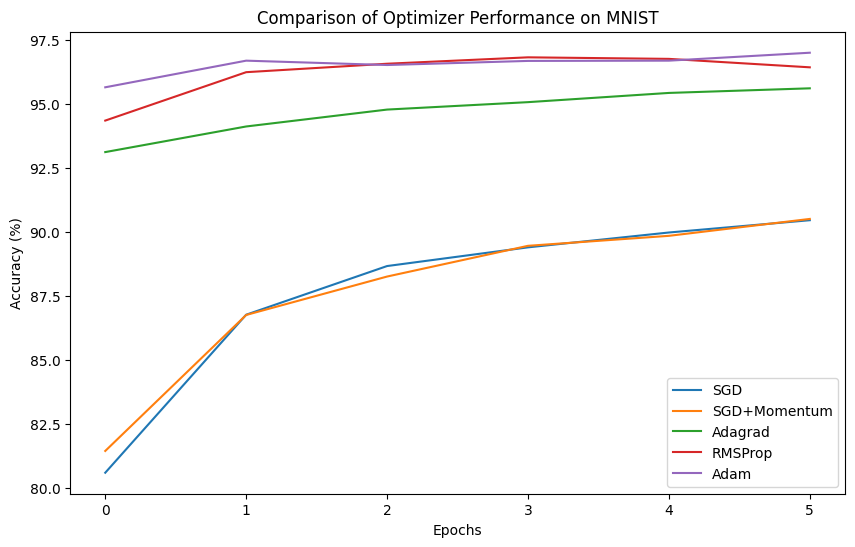

In [14]:
plt.figure(figsize=(10, 6))
for opt_name in accuracies:
    plt.plot(accuracies[opt_name], label=opt_name)

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Optimizer Performance on MNIST")
plt.legend()
plt.show()

# ➡️ **LAB02:** Regularization

In this exercise, you're going to implement and use different regularization techniques in PyTorch.

You will explore how regularization techniques help improve deep learning models by preventing overfitting and enhancing generalization. Regularization plays a crucial role in training robust models by constraining complexity and reducing dependency on specific patterns in the training data.

In this session, you’ll:

1. Split a training dataset into a training set and validation set

2. Implement 5 commonly used regularization techniques in Pytorch, and compare their impact on model performance and generalization:
    1. **L1 Regularization (Lasso)**

    2. **L2 Regularization (Ridge)**

    3. **Dropout**
    
    4. **Batch Normalization**

    5. **Early Stopping**

<br>  
By the end of this session, you will not only understand *how* these techniques work but also gain insights into their strengths and limitations when training neural networks. 
Let’s get started!

### Task 1 - Validation split

The MNIST dataset doesn't have a **validation dataset** yet. A validation dataset is needed to monitor the model's performance during training, so that we can determine when to tune hyperparameters or when to stop training, ensuring the model doesn't overfit to the training data.

<br>

**To Do: split the original training dataset into a training subset of 80% and a new validation set of 20%**

Find inspiration on the [PyTorch website](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [15]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Instantiate the neural network

In [16]:
# Define the baseline neural network model
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU(),
                nn.Linear(512, 64),        
                nn.ReLU(),
                nn.Linear(64, 10)
            )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

#### Define Training Function to Optimize Model Performance

In [17]:
# Define the training function
def train_model(model, trainloader, valloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    ## Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return running_loss / len(trainloader), val_loss / len(valloader)

#### Define Evaluation Function to Assess Model Performance

In [18]:
# Define the evaluation function
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return test_loss / len(testloader), correct / total

#### Define Plot Function to Plot Training and Test Loss Curve

In [19]:
# Function to plot the training loss curve
def plot_loss_curve(epochs, train_losses, val_losses, test_losses, title=""):
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train, Validation and Test Loss Curve - {title}')
    plt.legend()
    plt.grid()
    plt.show()

#### Model Training, Evaluation, and Loss Visualization

Epoch 1/30, Train Loss: 0.7205, Val Loss: 0.3228, Test Loss: 0.3026, Test Accuracy: 90.87%
Epoch 2/30, Train Loss: 0.2632, Val Loss: 0.2368, Test Loss: 0.2198, Test Accuracy: 93.47%
Epoch 3/30, Train Loss: 0.1899, Val Loss: 0.1799, Test Loss: 0.1626, Test Accuracy: 95.35%
Epoch 4/30, Train Loss: 0.1448, Val Loss: 0.1507, Test Loss: 0.1337, Test Accuracy: 96.04%
Epoch 5/30, Train Loss: 0.1141, Val Loss: 0.1287, Test Loss: 0.1115, Test Accuracy: 96.62%
Epoch 6/30, Train Loss: 0.0930, Val Loss: 0.1204, Test Loss: 0.1041, Test Accuracy: 96.93%
Epoch 7/30, Train Loss: 0.0773, Val Loss: 0.1129, Test Loss: 0.0995, Test Accuracy: 96.98%
Epoch 8/30, Train Loss: 0.0662, Val Loss: 0.1022, Test Loss: 0.0878, Test Accuracy: 97.25%
Epoch 9/30, Train Loss: 0.0553, Val Loss: 0.0977, Test Loss: 0.0808, Test Accuracy: 97.52%
Epoch 10/30, Train Loss: 0.0470, Val Loss: 0.0990, Test Loss: 0.0834, Test Accuracy: 97.47%
Epoch 11/30, Train Loss: 0.0411, Val Loss: 0.0868, Test Loss: 0.0713, Test Accuracy: 97.9

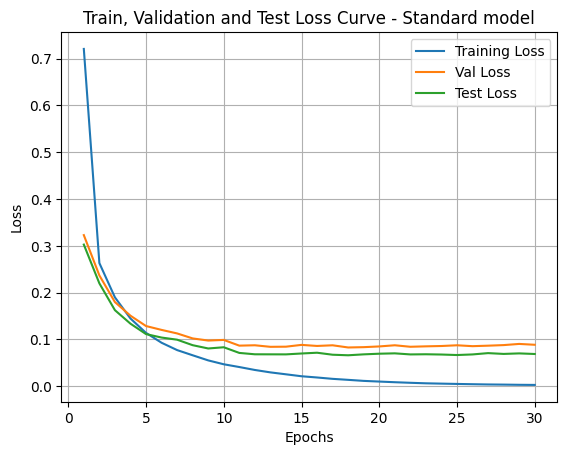

In [20]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the model
num_epochs = 30
train_losses = []
val_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")


# Plot the training loss curve
plot_loss_curve(num_epochs, train_losses, val_losses, test_losses, title="Standard model")

### Task 2.1 - L1 Regularization (Lasso)

Network overfitting can be caused by the model being too complex or overly sensitive to specific patterns in the training data.
This can be caused by large network weights, meaning that the model is highly responsive to small changes in input, making it sensitive to noise and outliers.

L1 regularization adds the absolute value of the model parameters (weights) as a penalty to the loss function, to encourage the model to learn smaller, simpler weights that generalize better to new data. L1 regularization encourages sparsity in the model by forcing some weights to become exactly zero, effectively selecting only the most important features. The equation is:

$$
L_1 = \lambda \sum_{i} \sum_{j} | w_{i,j} |
$$

where:
- $\lambda$ (lambda_reg) is a scaling factor that determines how much regularization is applied.
- $i$ indexes over all **layers** in the model.
- $j$ indexes over all **weights** in a given layer.
- $| w_{i,j} |$ represents the absolute value of each weight.

<br>

**Tip:** In PyTorch, **mathematical operations** are native to tensors, much like NumPy arrays. Please refer to the [PyTorch Pointwise Ops](https://pytorch.org/docs/stable/torch.html#pointwise-ops) and [PyTorch Reduction Ops](https://pytorch.org/docs/stable/torch.html#reduction-ops).

<br>

**To Do: Implement L1 regularization in the code below**

In [21]:
def l1_regularization(model, lambda_reg):
    l1_penalty = sum(param.abs().sum() for param in model.parameters())
    return lambda_reg * l1_penalty

### Task 2.2 - L2 Regularization (Ridge)

L2 regularization adds the squared value of the model parameters as a penalty to the loss function. L2 regularization prevents large weight values and encourages smaller, more evenly distributed weights, leading to better generalization. This is the equation:

$$
L_2 = \lambda \sum_{i} \sum_{j} w_{i,j}^2
$$

where:
- $\lambda$ (lambda_reg) is a scaling factor that determines how much regularization is applied.
- $i$ indexes over all **layers** in the model.
- $j$ indexes over all **weights** in a given layer.
- $w_{i,j}^2$ represents the squared value of each weight.

<br>

**Tip:** In PyTorch, **mathematical operations** are native to tensors, much like NumPy arrays. Please refer to the [PyTorch Pointwise Ops](https://pytorch.org/docs/stable/torch.html#pointwise-ops) and [PyTorch Reduction Ops](https://pytorch.org/docs/stable/torch.html#reduction-ops).

<br>

**To Do: Implement L2 regularization in the code below**

In [22]:
def l2_regularization(model, lambda_reg):
    l2_penalty = sum(param.pow(2).sum() for param in model.parameters())
    return lambda_reg * l2_penalty

### Task 2.1 & 2.2 - L1 and L2 regularization as parameter penalties

**To Do: Add the L1 and L2 regularization as components to the loss**

In [23]:
def train_model_w_regularization(model, trainloader, valloader, criterion, optimizer, regularization_type, lambda_reg):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if regularization_type == 'L1':
            loss += l1_regularization(model, lambda_reg)
        if regularization_type == 'L2':
            loss += l2_regularization(model, lambda_reg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    ## Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return running_loss / len(trainloader), val_loss / len(valloader)

#### Training and Evaluation of the Model with L1 Regularization

Epoch 1/30, Train Loss: 0.8222, Val Loss: 0.3121, Test Loss: 0.2956, Test Accuracy: 91.45%
Epoch 2/30, Train Loss: 0.3429, Val Loss: 0.2352, Test Loss: 0.2161, Test Accuracy: 93.46%
Epoch 3/30, Train Loss: 0.2720, Val Loss: 0.1790, Test Loss: 0.1655, Test Accuracy: 95.06%
Epoch 4/30, Train Loss: 0.2278, Val Loss: 0.1508, Test Loss: 0.1373, Test Accuracy: 95.88%
Epoch 5/30, Train Loss: 0.1996, Val Loss: 0.1325, Test Loss: 0.1191, Test Accuracy: 96.46%
Epoch 6/30, Train Loss: 0.1771, Val Loss: 0.1219, Test Loss: 0.1073, Test Accuracy: 96.77%
Epoch 7/30, Train Loss: 0.1617, Val Loss: 0.1158, Test Loss: 0.0957, Test Accuracy: 97.16%
Epoch 8/30, Train Loss: 0.1483, Val Loss: 0.1106, Test Loss: 0.0897, Test Accuracy: 97.13%
Epoch 9/30, Train Loss: 0.1374, Val Loss: 0.0961, Test Loss: 0.0810, Test Accuracy: 97.58%
Epoch 10/30, Train Loss: 0.1290, Val Loss: 0.1023, Test Loss: 0.0819, Test Accuracy: 97.49%
Epoch 11/30, Train Loss: 0.1217, Val Loss: 0.0917, Test Loss: 0.0753, Test Accuracy: 97.5

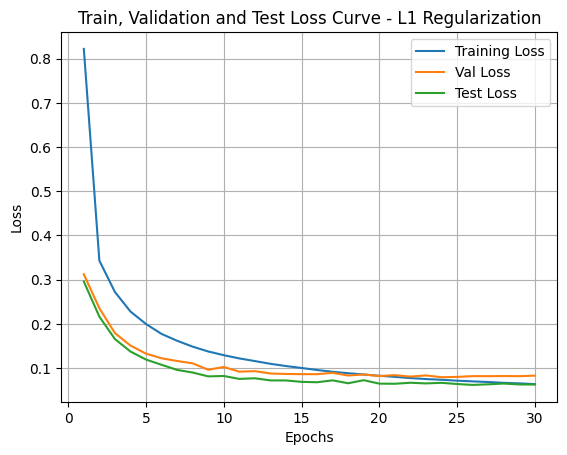

In [24]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the model
num_epochs = 30
lambda_reg = 1e-5
regularization_type = 'L1'
train_losses = []
val_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss, val_loss = train_model_w_regularization(model, train_loader, val_loader, criterion, optimizer, regularization_type, lambda_reg)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")


# Plot the training loss curve
plot_loss_curve(num_epochs, train_losses, val_losses, test_losses, title="L1 Regularization")

#### Training and Evaluation of the Model with L2 Regularization

Epoch 1/30, Train Loss: 0.8587, Val Loss: 0.3255, Test Loss: 0.3076, Test Accuracy: 90.87%
Epoch 2/30, Train Loss: 0.3859, Val Loss: 0.2420, Test Loss: 0.2283, Test Accuracy: 93.35%
Epoch 3/30, Train Loss: 0.3147, Val Loss: 0.1948, Test Loss: 0.1778, Test Accuracy: 94.72%
Epoch 4/30, Train Loss: 0.2722, Val Loss: 0.1652, Test Loss: 0.1448, Test Accuracy: 95.65%
Epoch 5/30, Train Loss: 0.2432, Val Loss: 0.1403, Test Loss: 0.1252, Test Accuracy: 96.26%
Epoch 6/30, Train Loss: 0.2229, Val Loss: 0.1283, Test Loss: 0.1104, Test Accuracy: 96.68%
Epoch 7/30, Train Loss: 0.2059, Val Loss: 0.1173, Test Loss: 0.0997, Test Accuracy: 97.12%
Epoch 8/30, Train Loss: 0.1934, Val Loss: 0.1104, Test Loss: 0.0968, Test Accuracy: 97.10%
Epoch 9/30, Train Loss: 0.1843, Val Loss: 0.1058, Test Loss: 0.0911, Test Accuracy: 97.32%
Epoch 10/30, Train Loss: 0.1756, Val Loss: 0.1043, Test Loss: 0.0885, Test Accuracy: 97.31%
Epoch 11/30, Train Loss: 0.1686, Val Loss: 0.0954, Test Loss: 0.0818, Test Accuracy: 97.5

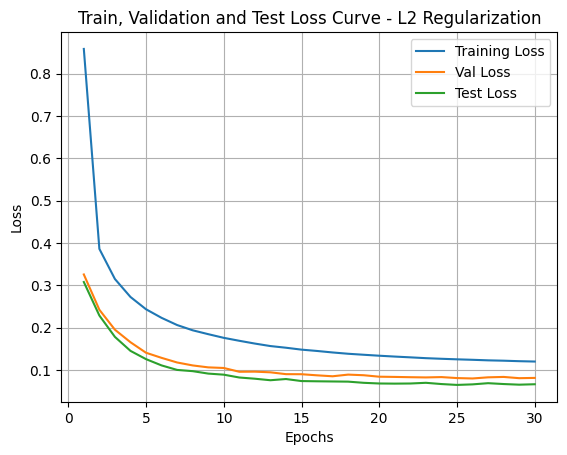

In [25]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the model
num_epochs = 30
lambda_reg = 5e-4
regularization_type = 'L2'
train_losses = []
val_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss, val_loss = train_model_w_regularization(model, train_loader, val_loader, criterion, optimizer, regularization_type, lambda_reg)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")


# Plot the training loss curve
plot_loss_curve(num_epochs, train_losses, val_losses, test_losses, title="L2 Regularization")

### Task 2.3 - Dropout 
Dropout is a regularization technique in deep learning that randomly deactivates a fraction of neurons during training to prevent overfitting. By introducing this randomness, dropout helps improve model generalization by reducing reliance on specific neurons and encouraging redundancy in learning.

<br>

**Tip:** In the lecture slides of Lesson 2 you can find the best placement of dropout in a neural network

<br>

**To Do: Add Dropout to the BaselineNN neural network architecture below**

In [26]:
class BaselineNN_with_Droupout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 64),        
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(64, 10)
            )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

#### Training and Evaluation of the Model with Dropout

Epoch 1/30, Train Loss: 0.9838, Val Loss: 0.3421, Test Loss: 0.3251, Test Accuracy: 90.61%
Epoch 2/30, Train Loss: 0.3974, Val Loss: 0.2330, Test Loss: 0.2153, Test Accuracy: 93.45%
Epoch 3/30, Train Loss: 0.2991, Val Loss: 0.1839, Test Loss: 0.1695, Test Accuracy: 94.74%
Epoch 4/30, Train Loss: 0.2438, Val Loss: 0.1560, Test Loss: 0.1418, Test Accuracy: 95.68%
Epoch 5/30, Train Loss: 0.2097, Val Loss: 0.1330, Test Loss: 0.1193, Test Accuracy: 96.35%
Epoch 6/30, Train Loss: 0.1856, Val Loss: 0.1207, Test Loss: 0.1072, Test Accuracy: 96.73%
Epoch 7/30, Train Loss: 0.1675, Val Loss: 0.1140, Test Loss: 0.0993, Test Accuracy: 97.00%
Epoch 8/30, Train Loss: 0.1531, Val Loss: 0.1107, Test Loss: 0.0943, Test Accuracy: 97.16%
Epoch 9/30, Train Loss: 0.1428, Val Loss: 0.1075, Test Loss: 0.0935, Test Accuracy: 97.09%
Epoch 10/30, Train Loss: 0.1313, Val Loss: 0.1007, Test Loss: 0.0876, Test Accuracy: 97.34%
Epoch 11/30, Train Loss: 0.1206, Val Loss: 0.0962, Test Loss: 0.0820, Test Accuracy: 97.5

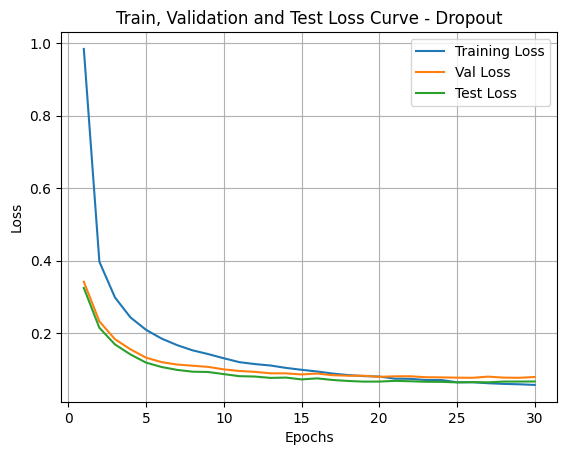

In [27]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN_with_Droupout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the model
num_epochs = 30
train_losses = []
val_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")


# Plot the training loss curve
plot_loss_curve(num_epochs, train_losses, val_losses, test_losses, title="Dropout")

### Task 2.4 - Early Stopping 
Early Stopping is a regularization technique used to prevent overfitting by monitoring the model’s performance on a validation set. Training stops when the validation loss stops improving for a predefined number of epochs, ensuring the model does not overfit to the training data.

The EarlyStopping class below helps to prevent overfitting by monitoring the validation loss during training. If the validation loss does not improve for a set number of epochs (defined by **patience**), training is stopped early. This ensures that the model does not continue to overfit the training data. The class tracks the best model state and restores it once early stopping is triggered, preserving the best-performing model. The **delta**  parameter allows for a minimum change in loss to be considered an improvement.

Source: [early-stopping-pytorch](https://github.com/Bjarten/early-stopping-pytorch/blob/main/early_stopping_pytorch/early_stopping.py)


In [28]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Training and Evaluation of the Model with Dropout and Early Stopping

**To Do: Integrate the EarlyStopping class with the appropriate inputs in the code below**

Epoch 1/100, Train Loss: 0.9696, Val Loss: 0.3414, Test Loss: 0.3232, Test Accuracy: 90.57%
Validation loss decreased (inf --> 0.3414).  Saving model ...
Epoch 2/100, Train Loss: 0.4000, Val Loss: 0.2328, Test Loss: 0.2151, Test Accuracy: 93.76%
Validation loss decreased (0.3414 --> 0.2328).  Saving model ...
Epoch 3/100, Train Loss: 0.3000, Val Loss: 0.1841, Test Loss: 0.1677, Test Accuracy: 94.82%
Validation loss decreased (0.2328 --> 0.1841).  Saving model ...
Epoch 4/100, Train Loss: 0.2472, Val Loss: 0.1528, Test Loss: 0.1385, Test Accuracy: 95.90%
Validation loss decreased (0.1841 --> 0.1528).  Saving model ...
Epoch 5/100, Train Loss: 0.2124, Val Loss: 0.1355, Test Loss: 0.1236, Test Accuracy: 96.23%
Validation loss decreased (0.1528 --> 0.1355).  Saving model ...
Epoch 6/100, Train Loss: 0.1876, Val Loss: 0.1287, Test Loss: 0.1138, Test Accuracy: 96.64%
Validation loss decreased (0.1355 --> 0.1287).  Saving model ...
Epoch 7/100, Train Loss: 0.1696, Val Loss: 0.1160, Test Loss:

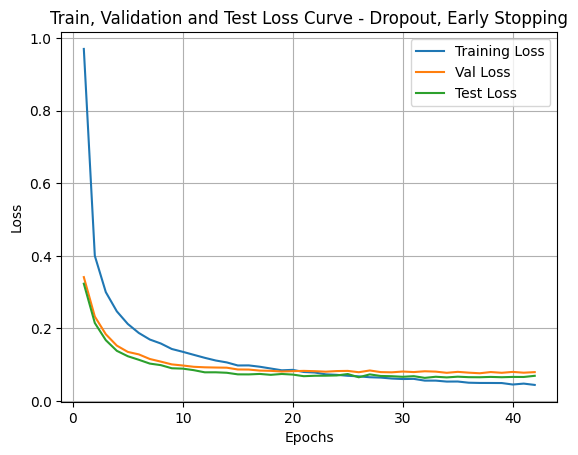

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineNN_with_Droupout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# EarlyStopping setup
early_stopping = EarlyStopping(path='best_model.pt', verbose=True)

num_epochs = 100
epochs_trained = 0
train_losses = []
val_losses = []
test_losses = []
# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")

    epochs_trained += 1
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Plot the training loss curve
plot_loss_curve(epochs_trained, train_losses, val_losses, test_losses, title="Dropout, Early Stopping")